### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torch.autograd import Variable


device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
#drive.flush_and_unmount()

In [4]:
!ls drive/MyDrive/celeba_data

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [6]:
!mkdir celeba
!cp drive/MyDrive/celeba_data/* celeba
!cp -R drive/MyDrive/CelebA/Img/img_align_celeba.zip ./celeba

mkdir: cannot create directory ‘celeba’: File exists


In [11]:
!ls celeba

identity_CelebA.txt   list_eval_partition.txt
img_align_celeba.zip  list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [12]:
!cd celeba && unzip img_align_celeba.zip && cd ..

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [13]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [14]:


#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    #download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.Normalize(0.5, 0.5)
    ]),
)

In [15]:
IMG_SHAPE = tuple(train_dataset[0][0].shape)

### Prepare Dataset

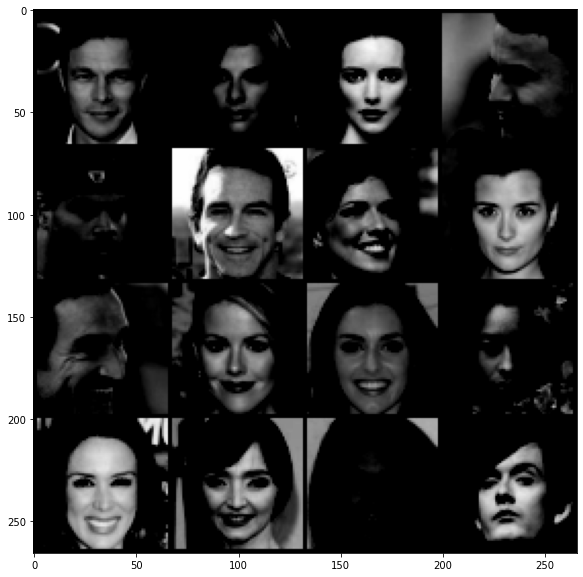

In [16]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid((1 + samples) / 2, nrow=4).permute(1, 2, 0))
plt.show()

max# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [55]:
MAX_VAL = 1e5;

def is_valid(tensor):
    pass
    #assert torch.sum(tensor.isnan()) == 0
    #assert torch.sum(torch.logical_or(tensor > MAX_VAL, tensor < -MAX_VAL)) == 0

In [18]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [59]:
#!L
CODE_SIZE = 100 # Size of z noise vector; feel free to change it


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # TODO

        self.generator = nn.Sequential(
            nn.Linear(CODE_SIZE, 16*8*8),
            Reshape([-1, 16, 8, 8]),
            nn.BatchNorm2d(16),
            nn.ELU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ELU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(4, 1, kernel_size=3, padding=1),
            nn.Tanh()

        )


    def forward(self, noise):
        return self.generator(noise)

generator = Generator().to(device)

In [60]:
noise = sample_noise_batch(100)
noise.shape

torch.Size([100, 100])

In [61]:
#!L
generated_data = generator(noise)
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

In [62]:
tmp = generator(sample_noise_batch(100))
print("min = {}".format(torch.min(tmp)))
print("max = {}".format(torch.max(tmp)))

min = -0.943607747554779
max = 0.887075662612915


### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [63]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [64]:
#!L
discriminator = nn.Sequential()

## YOUR CODE - create convolutional architecture for discriminator
## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

#!L
discriminator = nn.Sequential()

# reshape from "images" to flat vectors


discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same'))
discriminator.add_module('conv1_elu', nn.ELU())
discriminator.add_module('pool1', nn.AvgPool2d(2))

discriminator.add_module('conv2', nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding='same'))
discriminator.add_module('conv2_elu', nn.ELU())
discriminator.add_module('pool2', nn.AvgPool2d(2))

discriminator.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding='same'))
discriminator.add_module('conv3_elu', nn.ELU())
discriminator.add_module('pool3', nn.AvgPool2d(2))


discriminator.add_module('flatten', nn.Flatten())
# dense "head"
discriminator.add_module('dense1', nn.Linear(64 * 8 * 8, 16))
discriminator.add_module('dense1_elu', nn.ELU())
discriminator.add_module('dense2_logits', nn.Linear(16, 1)) 
#discriminator.add_module('sigmoid', nn.Sigmoid())



discriminator.to(device)

Sequential(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_elu): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_elu): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_elu): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=4096, out_features=16, bias=True)
  (dense1_elu): ELU(alpha=1.0)
  (dense2_logits): Linear(in_features=16, out_features=1, bias=True)
)

In [65]:
#!L
images = sample_data_batch(4)

In [66]:
images[0]

tensor([[[ 0.9687,  0.9696,  0.9696,  ...,  0.9618,  0.9618,  0.9618],
         [ 0.9687,  0.9696,  0.9696,  ...,  0.9618,  0.9618,  0.9618],
         [ 0.9687,  0.9696,  0.9696,  ...,  0.9618,  0.9618,  0.9618],
         ...,
         [ 0.8457,  0.7957,  0.7117,  ..., -0.2570, -0.3506, -0.4708],
         [ 0.8567,  0.7873,  0.7062,  ..., -0.3308, -0.4182, -0.3985],
         [ 0.8552,  0.7849,  0.6818,  ..., -0.3367, -0.4060, -0.3807]]],
       device='cuda:0')

In [67]:
predictions = discriminator(images)

In [68]:
predictions.shape

torch.Size([4, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [72]:
#!L
def generator_loss(generator, discriminator, noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    is_valid(generated_data)

    
    disc_on_fake_data = discriminator(generated_data)
    is_valid(disc_on_fake_data)

    real = Variable(torch.ones((generated_data.size(0), 1)).to(device), requires_grad=False)

    fake_loss = nn.BCEWithLogitsLoss()(disc_on_fake_data, real)

    is_valid(fake_loss)
    return fake_loss

In [73]:
#!L
loss = generator_loss(generator, discriminator, sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.7227, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [74]:
#!L
def discriminator_loss(generator, discriminator, real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """

    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    is_valid(disc_on_real_data)
    is_valid(disc_on_fake_data)

    real = Variable(torch.ones((generated_data.size(0), 1)).to(device), requires_grad=False)
    fake = Variable(torch.zeros((generated_data.size(0), 1)).to(device), requires_grad=False)

    real_loss = nn.BCEWithLogitsLoss()(disc_on_real_data, real)
    fake_loss = nn.BCEWithLogitsLoss()(disc_on_fake_data, fake)


    
    is_valid(real_loss)
    is_valid(fake_loss)

    return (real_loss + fake_loss) / 2

In [75]:
#!L
loss = discriminator_loss(generator, discriminator, 
                    sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.6928, device='cuda:0', grad_fn=<DivBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [76]:
#!L
def sample_images(generator, nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.squeeze().data.cpu().numpy()
    images = (1 + images) / 2
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(generator, discriminator, batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

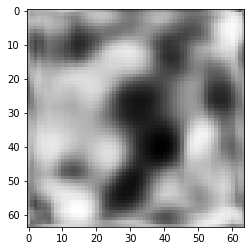

In [77]:
images = generator(sample_noise_batch(batch_size=1))
images = images.squeeze().data.cpu().numpy()
plt.imshow(images, cmap="gray", interpolation="none")

In [78]:

for name, param in discriminator.named_parameters():
    print("{} size {}  nans {} infs {}".format(name, param.size(), torch.isnan(param).sum(), torch.isinf(param).sum()))

conv1.weight size torch.Size([4, 1, 3, 3])  nans 0 infs 0
conv1.bias size torch.Size([4])  nans 0 infs 0
conv2.weight size torch.Size([16, 4, 3, 3])  nans 0 infs 0
conv2.bias size torch.Size([16])  nans 0 infs 0
conv3.weight size torch.Size([64, 16, 3, 3])  nans 0 infs 0
conv3.bias size torch.Size([64])  nans 0 infs 0
dense1.weight size torch.Size([16, 4096])  nans 0 infs 0
dense1.bias size torch.Size([16])  nans 0 infs 0
dense2_logits.weight size torch.Size([1, 16])  nans 0 infs 0
dense2_logits.bias size torch.Size([1])  nans 0 infs 0


In [79]:
class Functor(object):
    def __init__(self, prev):
        assert torch.isnan(prev).sum() == 0
        assert torch.isinf(prev).sum() == 0
        self.prev = prev

    def __call__(self, module):
        new_prev = module(self.prev)
        assert torch.isnan(new_prev).sum() == 0, "name = {}".format(module)
        assert torch.isinf(torch.logical_or(new_prev > 1e5, new_prev < -1e5)).sum() == 0, "name = {}".format(module)
        assert torch.isinf(new_prev).sum() == 0, "name = {}".format(module)
        self.prev = new_prev

def check_weights(data, net):
    func = Functor(data)
    net.apply(func)

In [80]:
#func = Functor(real_data[0:1])
#discriminator.apply(func)



### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [84]:
#!L
# optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [85]:
disc_scaler = torch.cuda.amp.GradScaler()
gen_scaler = torch.cuda.amp.GradScaler()

Only running training for one epoch for measuring perf. Network was already trained

# No improvement from half point precision

See previous commits for similar results with full precision

Idea: measure gpu mem consumption and use bigger batches (bigger lr?) to improve perf

epoch 1
Prev epoch taken 194.4141 seconds
iteration 600 out of 635


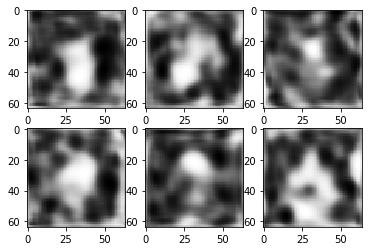

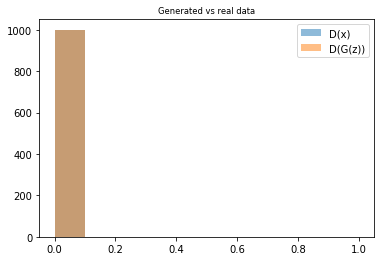

Last epoch taken 187.6362 seconds


In [86]:
#!L
from IPython import display
from tqdm.auto import tqdm
import time

batch_size = 256
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

prev_epoch_time = None

for epoch in range(2):
    start_time = time.perf_counter()
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        with torch.cuda.amp.autocast():
            real_data = batch.to(device)
            fake_data = generator(sample_noise_batch(batch_size))
            loss = discriminator_loss(generator, discriminator, real_data, fake_data)
        disc_opt.zero_grad(set_to_none=False)
        disc_scaler.scale(loss).backward()
        disc_scaler.step(disc_opt)
        disc_scaler.update()
        
        # Train generator
        if iteration % 5 == 0:
            with torch.cuda.amp.autocast():
                noise = sample_noise_batch(batch_size)
                loss = generator_loss(generator, discriminator, noise)
            gen_opt.zero_grad(set_to_none=False)
            gen_scaler.scale(loss).backward()
            gen_scaler.step(gen_opt)
            gen_scaler.update()

        if iteration % 100 == 0:
            display.clear_output(wait=True)
            print("epoch {}".format(epoch))
            if prev_epoch_time:
                print(f"Prev epoch taken {prev_epoch_time:0.4f} seconds")
            print("iteration {} out of {}".format(iteration, len(train_dataset) // batch_size))
            
            sample_images(generator, 2,3,True)
            sample_probas(generator, discriminator, 1000)
    prev_epoch_time = time.perf_counter() - start_time
    
print(f"Last epoch taken {prev_epoch_time:0.4f} seconds")

In [ ]:
#!L
plt.figure(figsize=[16, 24])
sample_images(generator, 16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please generate the same number of images as for autoencoders for a fair comparison.

In [ ]:
#!L
num_images = 10000
batch_size = 100

all_images = []

for batch_i in range(int((num_images - 1) / batch_size + 1)):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)